# Tutorial 

This notebook gives a short introduction on how to use the `ohsome` for sending requests to the ohsome API. We will perform a [Data Aggregation](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Aggregation) and [Data Extraction](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Extraction) queries.

#### Please refer to the documentation for a full description of all endpoints and query parameters.

&rarr; Endpoints refer to the [ohsome swagger documentation](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=dataExtraction)

&rarr; For more information on the parameters refer to the [ohsome API documentation](https://docs.ohsome.org/ohsome-api/stable/index.html), e.g. [filters](https://docs.ohsome.org/ohsome-api/stable/filter.html), [boundaries](https://docs.ohsome.org/ohsome-api/stable/boundaries.html), [time](https://docs.ohsome.org/ohsome-api/stable/time.html) and [grouping](https://docs.ohsome.org/ohsome-api/stable/group-by.html).

##### Import packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('..')

## 1. Metadata

All requests to the ohsome API are sent using an `OhsomeClient` object. 

In [4]:
from ohsome import OhsomeClient

In [5]:
client = OhsomeClient()

After its initialization you can query metadata of the ohsome API such as start and end timestamp, api version.

In [11]:
client.start_timestamp

'2007-10-08T00:00:00Z'

In [12]:
client.end_timestamp

'2021-01-30T03:00Z'

In [13]:
client.api_version

'1.3.2'

## 2. Data Aggregation

To send a request to one of the endpoints, append the single components of the endpoint URL as method calls to the client. Use code completion (TAB in jupyter) to find valid endpoint components. In the end, call the `post()` method with all necessary parameters to send off the query as a POST request.

### Number of highways

__Example:__ Number of features tagged as _highway=*_ within a bounding box in Heidelberg for the years 2010 and 2011. The call is sent to the endpoint [elements/count](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=dataExtraction#/Count/count_1)

In [16]:
bboxes = [8.67066,49.41423,8.68177,49.4204]
time = "2010-01-01/2011-01-01/P1Y"
filter = "highway=* and type:way"

In [17]:
response = client.elements.count.post(bboxes=bboxes, time=time, filter=filter)

Calling `as_dataframe()` converts the response to a `pandas.DataFrame` with the timestamp as index.

In [18]:
response_df = response.as_dataframe()

The result contains the number of highways for each time step:

In [7]:
response_df

,value
timestamp,
2010-01-01,53.0
2011-01-01,256.0


You can write the response to a JSON file using

In [8]:
response.to_file("./highways_count.json")

### Group number of highways by boundary

If you want to query the number of highways within several bounding boxes you can specify them using a nested list 

In [70]:
bboxes = [[8.67066,49.41423,8.68177,49.4204], [8.68551,49.40086,8.68937,49.40315]]

or a dictionary if you want to pass ids 

In [155]:
bboxes = {"INF": [8.67066,49.41423,8.68177,49.4204], "Weststadt": [8.68551,49.40086,8.68937,49.40315]}

To get separate counts for the bounding boxs, we need to ad `groupByBoundary` to the query.

In [72]:
response = client.elements.count.groupByBoundary.post(bboxes=bboxes, time=time, filter=filter)
response_df = response.as_dataframe()
response_df

value
boundary  timestamp                       
INF       2010-01-01 00:00:00+00:00  269.0
          2011-01-01 00:00:00+00:00  291.0
Weststadt 2010-01-01 00:00:00+00:00   13.0
          2011-01-01 00:00:00+00:00   13.0

The response is converted to a dataframe with a `MultiIndex`, which makes it easier to select subsets of the data based on the boundary and time attributes.

In [73]:
response_df.loc[("INF", slice(None)),:]

value
boundary timestamp                       
INF      2010-01-01 00:00:00+00:00  269.0
         2011-01-01 00:00:00+00:00  291.0

In [74]:
response_df.loc[(slice(None), "2010-01-01"),:]

,,value
boundary,timestamp,
INF,2010-01-01 00:00:00+00:00,269.0
Weststadt,2010-01-01 00:00:00+00:00,13.0


### Group number of highways by boundary and tag

Grouping the result by tag, will result in a dataframe with three index levels.

In [156]:
groupByKey = "highway"
filter = "highway=* and type:way"
response = client.elements.count.groupByBoundary.groupByTag.post(bboxes=bboxes, time=time, 
                                                                 filter=filter, groupByKey=groupByKey)
response_df = response.as_dataframe()

In [161]:
response_df.sort_index().loc[(slice(None), slice(None), "2010-01-01"),:].droplevel(2)

value
boundary  tag                         
INF       highway=access_ramp      0.0
          highway=construction     0.0
          highway=corridor         0.0
          highway=cycleway         5.0
          highway=footway        116.0
          highway=living_street    0.0
          highway=path             6.0
          highway=pedestrian       8.0
          highway=primary          8.0
          highway=residential     20.0
          highway=service         77.0
          highway=steps            9.0
          highway=track            3.0
          highway=unclassified    17.0
Weststadt highway=access_ramp      0.0
          highway=construction     0.0
          highway=corridor         0.0
          highway=cycleway         0.0
          highway=footway          1.0
          highway=living_street   11.0
          highway=path             0.0
          highway=pedestrian       0.0
          highway=primary          0.0
          highway=residential      1.0
          highway=service          0.0
          highway=steps            0.0
          highway=track            0.0
          highway=unclassified     0.0

## 2. Data Extraction

You can also download OSM features (and optionally their history) at any timestamp using the [Data Extraction](https://api.ohsome.org/v0.9/swagger-ui.html?urls.primaryName=Data%20Extraction) endpoints.

In [77]:
client = OhsomeClient()

### Extracting buildings

Extracting OSM features at a specific point in time is done through the [elements/geometry](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/) endpoint. It is also possible to only retrieve the [centroids](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Data%20Extraction/centroid_1) or [bounding boxes](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Data%20Extraction/bbox_1) of the features. 

__Example:__ Extract all building features with their geometry on 2010-01-01 at Heidelberg University. 

In [83]:
bboxes = [8.67066,49.41423,8.68177,49.4204]
time = "2020-01-01"
filter = "building=* and type:way"
properties = "tags" # to retreive OSM tags along with the geometries

In [79]:
response = client.elements.geometry.post(bboxes=bboxes, time=time, filter=filter, properties=properties)

Calling `as_geodataframe()` converts the response to a `geopandas.GeoDataFrame`.

In [80]:
response_gdf = response.as_geodataframe()

/Users/chludwig/miniconda3/envs/ohsomedev/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [81]:
response_gdf.head()

,,geometry,addr:housenumber,addr:street,amenity,building,name,access,fee,parking,building:levels,description,created_by,place_numbers,alt_name,addr:city,note
@osmId,@snapshotTimestamp,,,,,,,,,,,,,,,,
way/25205983,2010-01-01,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,Im Neuenheimer Feld,university,yes,Max-Planck-Institut für ausländisches öffentli...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/25208838,2010-01-01,"POLYGON ((8.67548 49.42040, 8.67549 49.42024, ...",522,Im Neuenheimer Feld,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/25238615,2010-01-01,"POLYGON ((8.67596 49.41583, 8.67524 49.41581, ...",NaN,NaN,parking,yes,NaN,private,yes,multi-storey,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/25298190,2010-01-01,"POLYGON ((8.67433 49.42014, 8.67433 49.41999, ...",501,Im Neuenheimer Feld,university,yes,Fakultät für Physik + Astronomie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
way/25298192,2010-01-01,"POLYGON ((8.67426 49.42040, 8.67426 49.42037, ...",502,Im Neuenheimer Feld,university,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


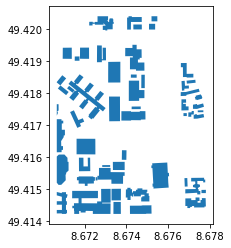

In [82]:
response_gdf.plot()

You may write the reponse to file using

In [16]:
response.to_file("./buildings_inf.geojson")

### Extracting Full History of OSM building 

Using the [elementsFullHistory](https://api.ohsome.org/v1/swagger-ui.html?urls.primaryName=Data%20Extraction#/Full-History%20Data%20Extraction/fullHistory_1) endpoints you can query all versions of the OSM features within a time period. 

__Example:__ Extract all buildings features with their history between 2010 and 2018.

In [84]:
bboxes = "8.67066,49.41423,8.68177,49.4204"
time = "2010-01-01,2018-01-01"
filter = "building=* and type:way"
properties = "tags" # to retreive OSM tags along with the geometries

In [85]:
client = OhsomeClient()
response = client.elementsFullHistory.geometry.post(bboxes=bboxes, time=time, filter=filter, properties=properties)

Using the method `as_geodataframe()` the response is converted to a `GeoDataFrame` with a multiindex containing OSM ID, validFrom and validTo parameters.

In [125]:
buildings_history = response.as_geodataframe()
buildings_history.head()

/Users/chludwig/miniconda3/envs/ohsomedev/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


geometry  \
@osmId        @validFrom          @validTo                                                                 
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18  POLYGON ((8.67066 49.41423, 8.67066 49.42040, ...   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17  POLYGON ((8.67066 49.41423, 8.67066 49.42040, ...   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31  POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...   
              2011-12-14 21:04:31 2012-02-24 14:17:07  POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...   
              2012-02-24 14:17:07 2012-07-17 05:25:02  POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...   

                                                      addr:housenumber  \
@osmId        @validFrom          @validTo                               
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18   cll 24 # 23-56   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17              NaN   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31              535   
              2011-12-14 21:04:31 2012-02-24 14:17:07              535   
              2012-02-24 14:17:07 2012-07-17 05:25:02              535   

                                                          building  \
@osmId        @validFrom          @validTo                           
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18  residential   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17          yes   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31          yes   
              2011-12-14 21:04:31 2012-02-24 14:17:07          yes   
              2012-02-24 14:17:07 2012-07-17 05:25:02          yes   

                                                      building:material  \
@osmId        @validFrom          @validTo                                
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18             brick   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17               NaN   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31               NaN   
              2011-12-14 21:04:31 2012-02-24 14:17:07               NaN   
              2012-02-24 14:17:07 2012-07-17 05:25:02               NaN   

                                                            addr:city  \
@osmId        @validFrom          @validTo                              
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18             NaN   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17  Cagayan De Oro   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31             NaN   
              2011-12-14 21:04:31 2012-02-24 14:17:07      Heidelberg   
              2012-02-24 14:17:07 2012-07-17 05:25:02      Heidelberg   

                                                      addr:postcode  \
@osmId        @validFrom          @validTo                            
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18           NaN   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17          9000   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31           NaN   
              2011-12-14 21:04:31 2012-02-24 14:17:07           NaN   
              2012-02-24 14:17:07 2012-07-17 05:25:02           NaN   

                                                          addr:province  \
@osmId        @validFrom          @validTo                                
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18               NaN   
way/450702564 2016-11-02 06:13:58 2016-11-02 09:06:17  Misamis Oriental   
way/25205983  2010-01-01 00:00:00 2011-12-14 21:04:31               NaN   
              2011-12-14 21:04:31 2012-02-24 14:17:07               NaN   
              2012-02-24 14:17:07 2012-07-17 05:25:02               NaN   

                                                               addr:street  \
@osmId        @validFrom          @validTo                                   
way/399317554 2016-02-22 21:12:04 2016-02-22 21:50:18                  NaN   
way/450702564 2016-11-02 06:13:58

Since the timestamp is given in the index, you can slice the data as before. 

**Example:** Select all versions of the OSM object with ID 'way/25205983'.

In [131]:
buildings_history.sort_index().loc["way/25205983",:]

,,geometry,addr:housenumber,building,building:material,addr:city,addr:postcode,addr:province,addr:street,amenity,name,...,fuel:octane_95,atm,wheelchair:toilet,books,shop,university,INF 230,layer,construction,stairwell
@validFrom,@validTo,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,2011-12-14 21:04:31,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,NaN,NaN,NaN,Im Neuenheimer Feld,university,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-14 21:04:31,2012-02-24 14:17:07,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,university,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-24 14:17:07,2012-07-17 05:25:02,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,yes,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-17 05:25:02,2014-05-10 22:08:51,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-10 22:08:51,2014-09-07 20:55:18,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,NaN,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-07 20:55:18,2015-05-03 10:16:40,"POLYGON ((8.67312 49.42040, 8.67312 49.42027, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-03 10:16:40,2016-07-28 15:44:48,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-28 15:44:48,2017-03-30 23:27:51,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-30 23:27:51,2018-01-01 00:00:00,"POLYGON ((8.67320 49.42040, 8.67320 49.42025, ...",535,university,NaN,Heidelberg,69120,NaN,Im Neuenheimer Feld,NaN,Max-Planck-Institut für ausländisches öffentli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Example:** Selecting all versions which have been created in 2015:

In [132]:
selected = buildings_history.sort_index().loc[(slice(None), 
                                    slice("2015-01-01","2015-12-31"), 
                                    slice(None)),:]

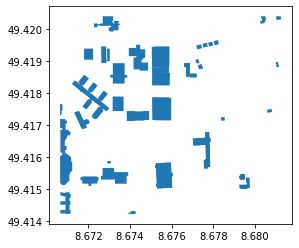

In [133]:
selected.plot()